# Steps: 1: Noise Scheduler

# 2: Neural Network (U-Net)

# 3: Timestop Encoding

In [14]:
#Reading into the data and plotting first 20 images

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image

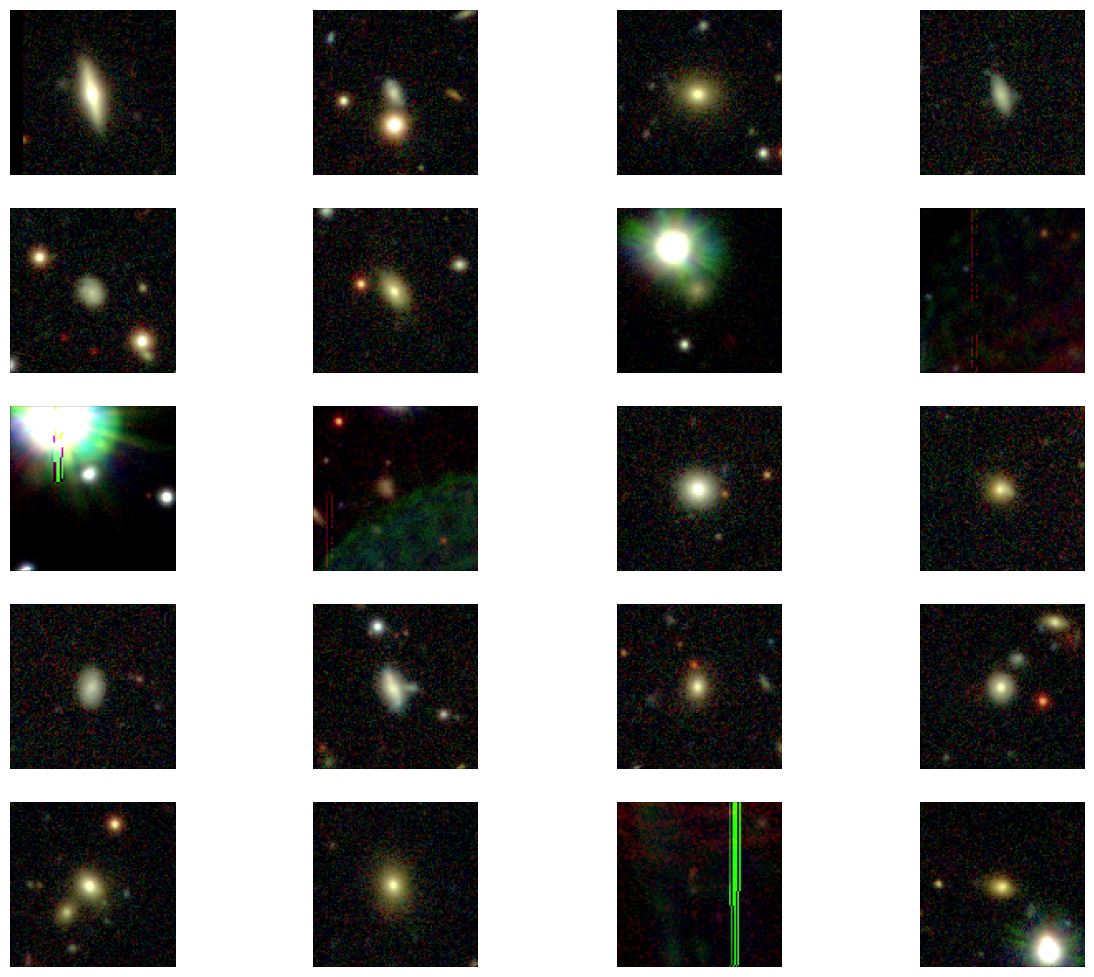

In [41]:
#Creating a function to Display the Dataset
def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15, 15)) 
    dataset_path = dataset  # Renamed the variable for clarity
    data = os.listdir(dataset_path)

    for i, file in enumerate(data):
        if i == num_samples:
            break
        image_path = os.path.join(dataset_path, file)
        img = Image.open(image_path)
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis
    plt.show()

data = "C:\\Users\\Usama Arshad\\Desktop\\Coursework\\Project Related Data\\Gamma Data\\g09\\Galaxies"
show_images(data)

In [42]:
import torch.nn.functional as F

In [63]:
#Defining Linear Beta Schedule

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

#to Extract Indexes from a list

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 150
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [44]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt


In [45]:
from torchvision.datasets import ImageFolder


In [64]:

IMG_SIZE = 64
BATCH_SIZE = 128

dataset_path = r"C:\\Users\\Usama Arshad\\Desktop\\Coursework\\Project Related Data\\Gamma Data\\g09"

# Custom dataset loading and transformation
def load_custom_dataset(dataset_path, transform):
    dataset = ImageFolder(root=dataset_path, transform=transform)
    return dataset

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),
        transforms.ToPILImage()
    ])
    # Select the first item from the 4-dimensional tensor
    img = image[0]
    # Display the image
    plt.imshow(reverse_transforms(img))
    plt.show()

# Transformation for the dataset
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(), #Doing Data Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

# Load  custom dataset
data = load_custom_dataset(dataset_path, data_transform)

# Create a DataLoader for  dataset
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [47]:
#Test the function calls step by step

C:\Users\Usama Arshad\AppData\Local\Temp\ipykernel_1376\1509478405.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


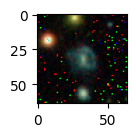

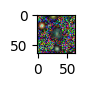

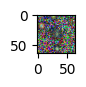

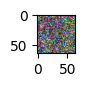

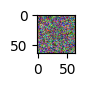

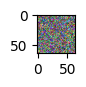

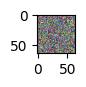

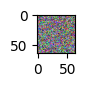

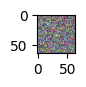

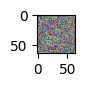

In [65]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

# Step 2: The backward process = U-Net

In [49]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
       
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

# Step 3: The loss

In [50]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [51]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

Training

Epoch 0 | step 000 Loss: 0.15665163099765778 
Epoch 0 | step 000 Loss: 0.15665163099765778 


C:\Users\Usama Arshad\AppData\Local\Temp\ipykernel_1376\364762590.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


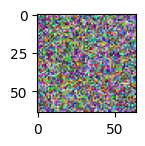

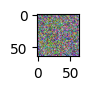

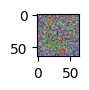

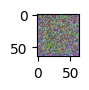

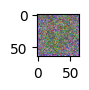

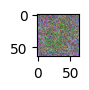

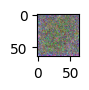

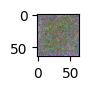

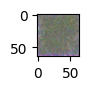

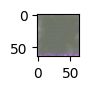

Epoch 0 | step 001 Loss: 0.35921624302864075 
Epoch 0 | step 002 Loss: 0.2792622745037079 
Epoch 0 | step 003 Loss: 0.25006410479545593 
Epoch 0 | step 004 Loss: 0.268192321062088 
Epoch 0 | step 005 Loss: 0.289968878030777 
Epoch 0 | step 006 Loss: 0.27625206112861633 
Epoch 0 | step 007 Loss: 0.23636563122272491 
Epoch 0 | step 008 Loss: 0.22939349710941315 
Epoch 0 | step 009 Loss: 0.21802262961864471 
Epoch 0 | step 010 Loss: 0.22255049645900726 
Epoch 0 | step 011 Loss: 0.19959206879138947 
Epoch 0 | step 012 Loss: 0.21596650779247284 
Epoch 0 | step 013 Loss: 0.19004814326763153 
Epoch 0 | step 014 Loss: 0.18748553097248077 
Epoch 0 | step 015 Loss: 0.1992899626493454 
Epoch 0 | step 016 Loss: 0.19599103927612305 
Epoch 0 | step 017 Loss: 0.2093590646982193 
Epoch 0 | step 018 Loss: 0.2149045467376709 
Epoch 0 | step 019 Loss: 0.18386465311050415 
Epoch 0 | step 020 Loss: 0.2197660654783249 
Epoch 0 | step 021 Loss: 0.19996817409992218 
Epoch 0 | step 022 Loss: 0.2039869278669357

Epoch 0 | step 181 Loss: 0.14797984063625336 
Epoch 0 | step 182 Loss: 0.18386435508728027 
Epoch 0 | step 183 Loss: 0.15895430743694305 
Epoch 0 | step 184 Loss: 0.1783197969198227 
Epoch 0 | step 185 Loss: 0.15772216022014618 
Epoch 0 | step 186 Loss: 0.17054013907909393 
Epoch 0 | step 187 Loss: 0.14645898342132568 
Epoch 0 | step 188 Loss: 0.15723514556884766 
Epoch 0 | step 189 Loss: 0.15205968916416168 
Epoch 0 | step 190 Loss: 0.17597264051437378 
Epoch 0 | step 191 Loss: 0.15656550228595734 
Epoch 0 | step 192 Loss: 0.16357852518558502 
Epoch 0 | step 193 Loss: 0.156157985329628 
Epoch 0 | step 194 Loss: 0.1520518660545349 
Epoch 0 | step 195 Loss: 0.14538434147834778 
Epoch 0 | step 196 Loss: 0.15770083665847778 
Epoch 0 | step 197 Loss: 0.1312251091003418 
Epoch 0 | step 198 Loss: 0.14697135984897614 
Epoch 0 | step 199 Loss: 0.1273929476737976 
Epoch 0 | step 200 Loss: 0.164930060505867 
Epoch 0 | step 201 Loss: 0.15291763842105865 
Epoch 0 | step 202 Loss: 0.155006036162376

Epoch 0 | step 361 Loss: 0.13235735893249512 
Epoch 0 | step 362 Loss: 0.15431274473667145 
Epoch 0 | step 363 Loss: 0.13905204832553864 
Epoch 0 | step 364 Loss: 0.1284872442483902 
Epoch 0 | step 365 Loss: 0.15435771644115448 
Epoch 0 | step 366 Loss: 0.1410222351551056 
Epoch 0 | step 367 Loss: 0.13059575855731964 
Epoch 0 | step 368 Loss: 0.13936948776245117 
Epoch 0 | step 369 Loss: 0.16918319463729858 
Epoch 0 | step 370 Loss: 0.1420784741640091 
Epoch 0 | step 371 Loss: 0.15024876594543457 
Epoch 0 | step 372 Loss: 0.12923230230808258 
Epoch 0 | step 373 Loss: 0.1316625028848648 
Epoch 0 | step 374 Loss: 0.1346483677625656 
Epoch 0 | step 375 Loss: 0.14627523720264435 
Epoch 0 | step 376 Loss: 0.1509440392255783 
Epoch 0 | step 377 Loss: 0.1591467410326004 
Epoch 0 | step 378 Loss: 0.12672074139118195 
Epoch 0 | step 379 Loss: 0.1434042602777481 
Epoch 0 | step 380 Loss: 0.15357506275177002 
Epoch 0 | step 381 Loss: 0.13617974519729614 
Epoch 0 | step 382 Loss: 0.134358927607536

In [68]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        
      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

In [36]:
#Code was inspired from https://www.youtube.com/watch?v=a4Yfz2FxXiY (Acccessed September 2023)

In [37]:
#Mathematical Equations for diffusion and the baseline idea is used from Ho et al., (2020)

# Calculating FID Score for the Generated Images

In [3]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

In [4]:
def load_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        images.append(img_array)
    return np.array(images)

def calculate_fid(images1, images2):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    features1 = model.predict(images1)
    features2 = model.predict(images2)

    mu1, sigma1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * 1e-6
        covmean = sqrtm((sigma1 + offset) @ (sigma2 + offset))

    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

generated_images_dir = 'C:\\Users\\Usama Arshad\\Desktop\\Coursework\\Project Related Data\\Gamma Data\\Gen'
real_images_dir = 'C:\\Users\\Usama Arshad\\Desktop\\Coursework\\Project Related Data\\Gamma Data\\Real'

# Load images from directories
generated_images = load_images_from_directory(generated_images_dir)
real_images = load_images_from_directory(real_images_dir)

# Calculate Fréchet Inception Distance
fid_score = calculate_fid(real_images, generated_images)
print(f'Fréchet Inception Distance: {fid_score}')

2/2 [==============================] - 3s 1s/step
Fréchet Inception Distance: (87.2031949963096-2.7739715038795197e-06j)


In [1]:
#Code Snippets were taken from ChatGPT for this code